# Cycle computation & Apertium RDF dictionaries. Analysing contexts.

This is a quick analysis of the contexts (local graphs) we get when running the experiment on all English nouns from the Apertium RDF data (Targets-EN.txt). See the README file to know how the data was generated.

For each source-target pair: the source word is the index of the data frame and the columns correspond to:

    Word: the source English word.
    Cycles: the number of cycles with source & target words.
    Cycles_U: number of 'unique' cycles with source & target words (abcda = acdba).
    Nodes: number of nodes in the Word graph (the local context for Word).
    Edges: number of edges in the Word graph (the local context for Word).
    Targets: number of already known targets for Word in the Apertium data.
    pT: number of potential targets for Word (nodes in cycles not linked to Word).
    Graph_D: graph density (density of the context).


In [100]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore

# Read input data file and drop unwanted columns. 
df = pd.read_csv('Targets-EN.txt', header=None)
#print(df.head())
df.drop(df.columns[[8,9,10,11,12]], axis=1, inplace=True)
df = df.drop_duplicates()
df.columns = ['Word', 'Cycles', 'Cycles_U', 'Nodes', 'Edges', 'Targets', 'pT', 'Graph_D']
df = df.set_index('Word')

df.head()

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
Word,,,,,,,
abacus-n-en,18,6,16,33,3,1,0.138
abandonment-n-en,160,27,32,72,9,4,0.073
abbey-n-en,18,6,12,31,3,1,0.235
abbot-n-en,18,6,15,32,4,1,0.152
abbreviation-n-en,18,6,16,34,3,1,0.142


In [101]:
# Describe the data frame
df.describe()

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
count,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000
mean,518.893535,101.088691,36.985015,80.528838,5.798920,4.242202,0.135629
std,3853.895159,770.314732,33.727257,67.286668,3.067611,3.690523,0.117545
min,2.000000,1.000000,4.000000,8.000000,2.000000,1.000000,0.007000
25%,18.000000,6.000000,14.000000,36.000000,4.000000,2.000000,0.044000
50%,92.000000,21.000000,25.000000,59.000000,5.000000,3.000000,0.095000
75%,347.000000,68.000000,48.000000,102.000000,7.000000,5.000000,0.205500
max,193536.000000,38894.000000,284.000000,608.000000,28.000000,40.000000,0.833000


In [102]:
# List top 5 by Cycles
df.sort_values(by='Cycles', ascending=False).head(5)

# big contexts (high nodes and edges) + high number of Targets produce lots of cycles. 

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
Word,,,,,,,
boy-n-en,193536,38894,198,608,21,40,0.016
girl-n-en,185026,36745,188,595,23,39,0.017
child-n-en,50224,11897,166,529,19,37,0.019
work-n-en,40118,6719,119,350,20,24,0.025
kid-n-en,29018,5672,133,390,11,25,0.022


In [103]:
# List top 5 by Graph Density
df.sort_values(by='Graph_D', ascending=False).head(5)

# small contexts are more dense...

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
Word,,,,,,,
churn-n-en,4,2,4,10,2,1,0.833
minimisation-n-en,4,2,4,10,2,1,0.833
Scorpio-n-en,4,2,4,10,2,1,0.833
deconcentration-n-en,4,2,4,10,2,1,0.833
examinee-n-en,4,2,4,10,2,1,0.833


In [104]:
# List top 5 by Targets (already known translations in Apertium data)
df.sort_values(by='Targets', ascending=False).head(5)

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
Word,,,,,,,
fan-n-en,1722,335,151,352,28,20,0.016
failure-n-en,1866,419,160,377,27,23,0.015
target-n-en,15834,3040,127,343,26,18,0.021
expansion-n-en,232,31,107,212,25,8,0.019
release-n-en,1118,126,85,223,23,13,0.031


In [105]:
# List top 10 'productive' (highest  in 'Potential Targets - Targets'; more candidates than known translations.

df['diff'] = df.pT - df.Targets
print(df.sort_values(by='diff', ascending=False).head(10))

# Remove the diff column
df.drop(df.columns[[7]], axis=1, inplace=True)

                Cycles  Cycles_U  Nodes  Edges  Targets  pT  Graph_D  diff
Word                                                                      
boy-n-en        193536     38894    198    608       21  40    0.016    19
lad-n-en         28336      4637    140    388        8  26    0.020    18
child-n-en       50224     11897    166    529       19  37    0.019    18
direction-n-en    2240       629    130    312       13  30    0.019    17
girl-n-en       185026     36745    188    595       23  39    0.017    16
infant-n-en      14986      3611    130    376        9  24    0.022    15
purpose-n-en      1626       454    150    332        8  23    0.015    15
kid-n-en         29018      5672    133    390       11  25    0.022    14
edge-n-en         6696      1753    284    597       18  32    0.007    14
brink-n-en         436       156    167    302        6  19    0.011    13


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280C34D02E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000280C952AEF0>]], dtype=object)

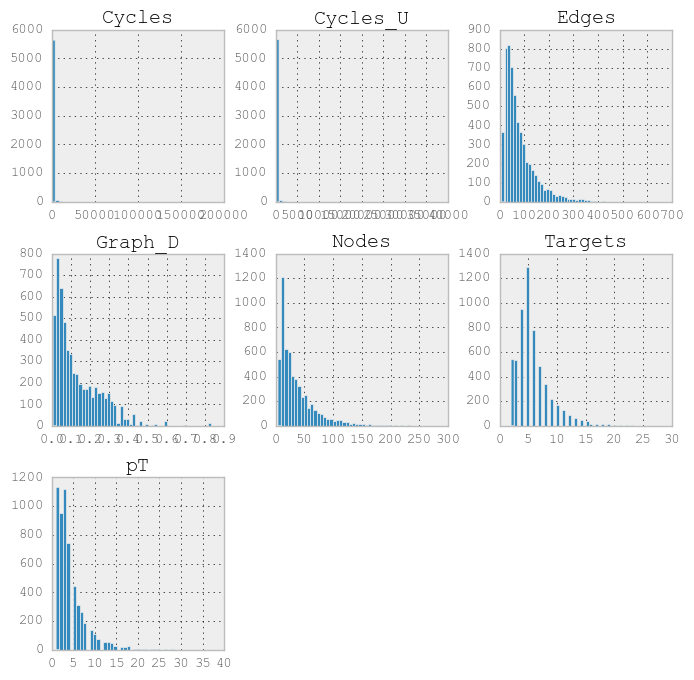

In [106]:
# Histograms (all data)

%matplotlib inline  

df.hist(bins=50, figsize=(8,8))

## Zscore and outliers:

In [107]:
# Zscore and outliers. Identify outliers using  Cycle zscore > 3
# We only get 19 outliers

# Calculate zscores for all data frame
dfZ = df.apply(zscore)
#print(dfZ.head(10))

# Get outliers using  Cycle zscore > 3
dfZ.loc[dfZ['Cycles'] >  3]

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
Word,,,,,,,
aim-n-en,3.281410,2.332901,3.024968,3.544416,1.695630,3.457209,-1.009305
boy-n-en,50.088006,50.364208,4.774447,7.839846,4.955779,9.689931,-1.017813
change-n-en,3.312550,2.810669,5.011665,4.896956,2.999690,2.915233,-1.068862
child-n-en,12.898492,15.314441,3.825577,6.665663,4.303749,8.876967,-0.992289
end-n-en,3.546619,2.826249,2.906359,3.291744,2.347660,2.373257,-1.009305
enquiry-n-en,3.253383,2.136860,2.224359,3.024208,2.021645,2.644245,-0.958257
girl-n-en,47.879658,47.574196,4.477926,7.646626,5.607809,9.418943,-1.009305
goal-n-en,4.446566,4.023266,5.100622,5.729289,4.955779,5.083136,-1.060354
infant-n-en,3.754219,4.556861,2.758098,4.391612,1.043600,5.354124,-0.966765


In [108]:
# Zscore and outliers. Identify outliers using  Density zscore > 3

dfZ.loc[dfZ['Graph_D'] > 3]

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
Word,,,,,,,
anatomist-n-en,-0.134134,-0.129944,-0.948426,-1.048276,-1.238505,-0.607610,3.100104
anthrax-n-en,-0.134134,-0.129944,-0.948426,-1.048276,-1.238505,-0.878598,3.100104
asepsis-n-en,-0.133615,-0.128645,-0.948426,-1.033413,-1.238505,-0.878598,3.525508
barony-n-en,-0.133096,-0.127347,-0.948426,-0.988823,-1.238505,-0.607610,4.801722
batiste-n-en,-0.133615,-0.128645,-0.948426,-1.033413,-1.238505,-0.878598,3.525508
battleground-n-en,-0.134134,-0.129944,-0.948426,-1.048276,-1.238505,-0.878598,3.100104
cassation-n-en,-0.129982,-0.123452,-0.948426,-0.959097,-0.912490,-0.878598,5.652532
castilianisation-n-en,-0.133615,-0.128645,-0.948426,-1.018550,-1.238505,-0.878598,3.950913
churn-n-en,-0.133615,-0.128645,-0.978078,-1.048276,-1.238505,-0.878598,5.933299


In [109]:
# Remove outliers (Those with Z-score < 3 in some column)
print(len(df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]) - len(df))
dfClean = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
dfClean.describe()

# we have 278 outliers

-279


,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,335.111355,63.631136,33.178388,72.669231,5.521429,3.860623,0.134810
std,756.205749,135.323545,25.697289,50.315150,2.485219,2.814303,0.105405
min,2.000000,1.000000,5.000000,9.000000,2.000000,1.000000,0.012000
25%,18.000000,6.000000,14.000000,36.000000,4.000000,2.000000,0.047000
50%,84.000000,21.000000,24.000000,57.000000,5.000000,3.000000,0.099000
75%,294.000000,63.000000,45.000000,96.000000,7.000000,5.000000,0.209000
max,11534.000000,2345.000000,138.000000,282.000000,15.000000,15.000000,0.476000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280C9D8B668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000280C9BB15C0>]], dtype=object)

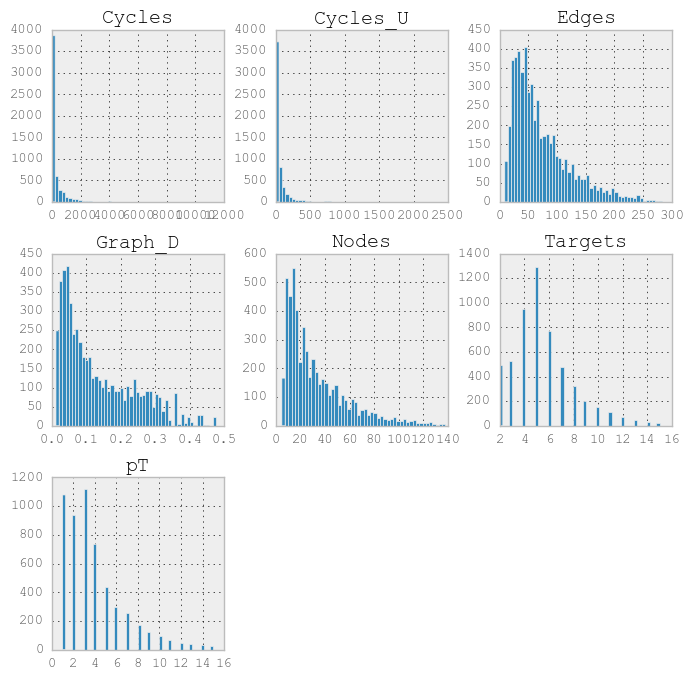

In [110]:
# Histograms
dfClean.hist(bins=50, figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280C80E71D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000280C7DC10F0>]], dtype=object)

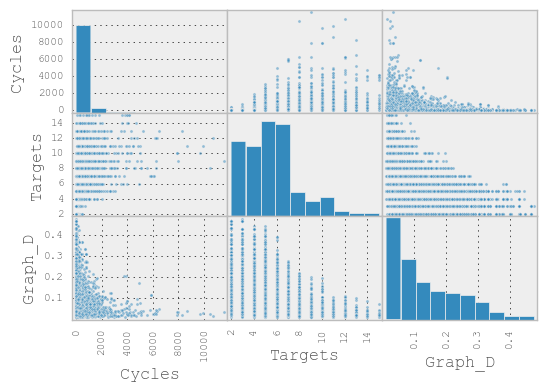

In [111]:
# Plottings
from pandas.tools import plotting
plotting.scatter_matrix(dfClean[['Cycles', 'Targets', 'Graph_D']])   


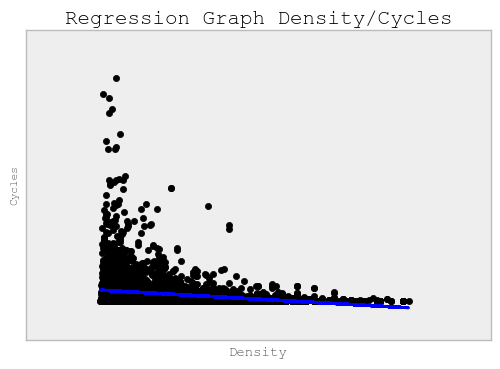

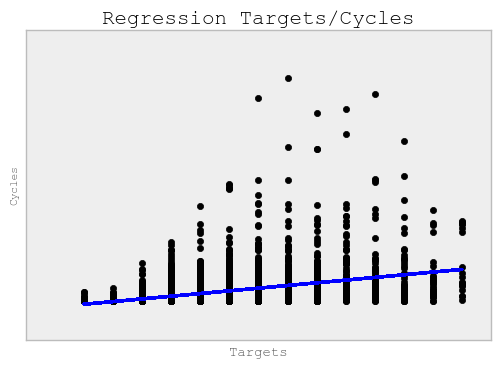

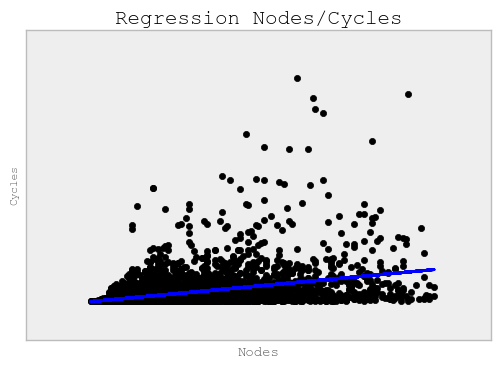

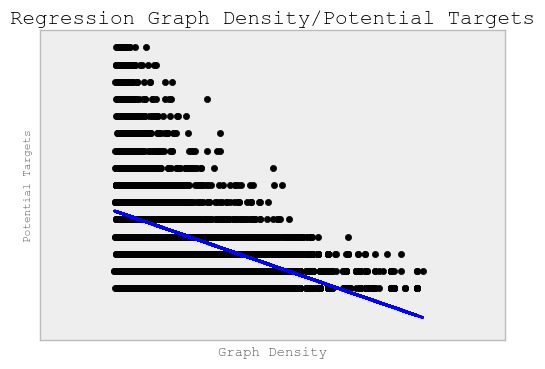

In [112]:
# 'Regression' plots for data without outliers (change dfClean by df if you want to include outliers)
from sklearn import datasets, linear_model

def plot_matrix(matrix,a,b,titleX,titleY,title):
    x, y = npMatrix[:,a], npMatrix[:,b]
    
    x = x.reshape(len(x), 1)
    y = y.reshape(len(y), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black')
    plt.plot(x, regr.predict(x), color='blue', linewidth=2)
    plt.xticks(())
    plt.yticks(())
    plt.title(title, fontsize = 15)
    plt.xlabel(titleX, fontsize = 10)
    plt.ylabel(titleY, fontsize = 8)
    plt.show()
    
# Choose matrix

#npMatrix = np.matrix(df)
npMatrix = np.matrix(dfClean)

# Change column numbers as desired
plot_matrix(npMatrix,6,0,"Density","Cycles","Regression Graph Density/Cycles")

plot_matrix(npMatrix,4,0,"Targets","Cycles","Regression Targets/Cycles")

plot_matrix(npMatrix,2,0,"Nodes","Cycles","Regression Nodes/Cycles")

plot_matrix(npMatrix,6,5, "Graph Density","Potential Targets","Regression Graph Density/Potential Targets")

